# **NYU Tandon Bridge - BERT + K-Means Clustering**
https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Others:
https://github.com/ddangelov/Top2Vec
https://github.com/MaartenGr/BERTopic

In [ ]:
!pip install -q sentence-transformers
!pip install -q umap-learn

     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 1.8MB 24.2MB/s 
     |████████████████████████████████| 1.2MB 53.8MB/s 
     |████████████████████████████████| 890kB 49.7MB/s 
     |████████████████████████████████| 3.2MB 55.2MB/s 


In [ ]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from scipy import spatial
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import umap
from sentence_transformers import SentenceTransformer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## **A. Data Preprocessing**

In [ ]:
path = "drive/MyDrive/data/tandon_bridge/"
# Import raw json data
with open(path+"data/preprocessed/transcripts.json", "r") as f:
    raw_transcript = json.load(f)

with open(path+"data/preprocessed/ppts.json", "r") as f:
    raw_ppt = json.load(f)

In [ ]:
# --- Data Preprocessing ------------------------------------------------------

# # Init Spacy
# nlp = spacy.load('en_core_web_lg')
# Define the stop words list
stop_words = set(stopwords.words('english'))
# Define stemmer
stemmer = PorterStemmer()
# Define lemmatizer
lemmatizer = WordNetLemmatizer()
# Define tf-idf vectorizer
vectorizer = TfidfVectorizer()


# Text preprocessing pipeline for the model
def text_preprocessing_1(lines):
    # Join lines into a string
    line = " ".join(lines)
    # Lowercase
    line = line.lower()
    # Remove symbols and numbers
    # line = re.sub(r'[^a-zA-Z]+', ' ', line)
    # Normalizing whitespaces
    line = line.split()
    # Remove stopwords and discards words of length < 3
    # line = [token for token in line if token not in stop_words and len(token) > 3]
    # Lemmatize the verbs and then stem
    # line = [stemmer.stem(lemmatizer.lemmatize(token, pos='v')) for token in line]
    # Join words to string
    line = ' '.join(line)
    return line


# Converts raw data to dataframe where each doc is a slide or transcript para
def convert_to_dataframe(raw_ppt, explode_col, text_col):
    df = pd.DataFrame(raw_ppt)
    df = df.explode(explode_col)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, pd.DataFrame(df[explode_col].to_list())], axis=1)
    df.drop(explode_col, axis=1, inplace=True)
    df[text_col] = df[text_col].apply(text_preprocessing_1)
    return df


# Apply conversion
df_ppt = convert_to_dataframe(raw_ppt, "ppt", "slide_text")
df_transcript = convert_to_dataframe(raw_transcript, "transcript", "data")

# Extract the text data
# data = df_ppt["slide_text"].to_list() + df_transcript["data"].to_list()
# mod_nos = df_ppt["module_number"].to_list() + df_transcript['module_number'].to_list()
data = df_transcript["data"].to_list()
mod_nos = df_transcript['module_number'].to_list()
# data = df_ppt["slide_text"].to_list()
# mod_nos = df_transcript['slide_text'].to_list()



## B. Embeddings

In [ ]:
# Distilbert gives good speed + performance
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

# IMPORTANT: Must make sure that the data adheres the 512 token limit of BERT.
# ELSE SPLIT THE DOCS INTO MULTIPLE PARAGRAPHS 

100%|██████████| 245M/245M [00:11<00:00, 22.0MB/s]


## C. Clustering

It will help us in determining a suitable number of topics for the topic model.

### C.1. Dimensionality Reduction (UMAP)

In [ ]:
neighbors = 10

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=neighbors, 
                            n_components=256, 
                            metric='cosine').fit_transform(embeddings)

In [ ]:
# data[1]

### C.2 Clustering (K-Means)

In [ ]:
cluster = KMeans(n_clusters=7, random_state=0).fit(umap_embeddings)

In [ ]:
# cluster.labels_

In [ ]:
# cluster = hdbscan.HDBSCAN(min_cluster_size=neighbors,
#                           metric='euclidean',                      
#                           cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
umap_data = umap.UMAP(n_neighbors=neighbors, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

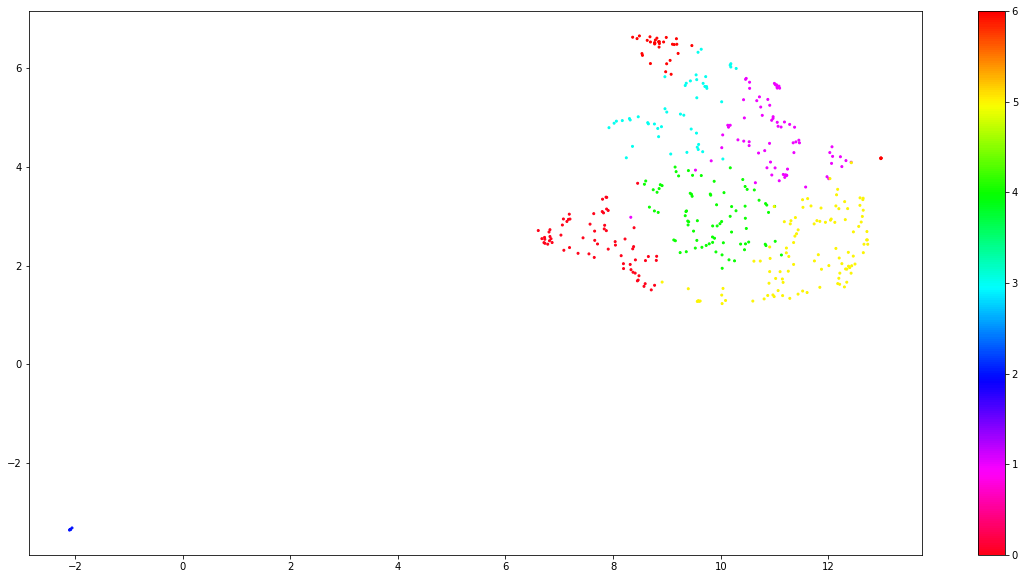

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='black', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=4, cmap='hsv_r')
plt.colorbar()

### C.3. Classwise TF-IDF

In [ ]:
# Prepare df
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
# Classwise tf-idf
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
# Apply tfidf and get scores for each word
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


## D. Topic Creation

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

,Topic,Size
5,5,104
4,4,79
1,1,71
0,0,68
3,3,47
6,6,34
2,2,6


## Topic Words

In [ ]:
topic_words = {}
for i in range(len(top_n_words)-1):
  w = []
  for j in top_n_words[i]:
    w.append(j[0])
  topic_words[i] = w

In [ ]:
topic_words

{0: ['branch',
  'registers',
  'register',
  'fetch',
  'stage',
  'ram',
  'load',
  'cpu',
  'level',
  'machine',
  'execute',
  'instructions',
  'address',
  'segment',
  'target',
  'controller',
  'cache',
  'offset',
  'pipeline',
  'cycle'],
 1: ['hour',
  'ascending',
  'true',
  'low',
  'expression',
  'print',
  'range',
  'index',
  'assumption',
  'string',
  'reference',
  'numbers',
  'mid',
  'min',
  'minus',
  'seven',
  'high',
  'induction',
  'absolute',
  'smaller'],
 2: ['zeros',
  'estimate',
  'events',
  'event',
  'evenly',
  'evaluation',
  'evaluating',
  'evaluates',
  'evaluated',
  'evaluate',
  'europe',
  'ethernet',
  'ether',
  'etcetera',
  'estimation',
  'essentially',
  'everybody',
  'essential',
  'especially',
  'escape'],
 3: ['students',
  'child',
  'grades',
  'average',
  'height',
  'children',
  'arr',
  'ninety',
  'ileft',
  'position',
  'balance',
  'sub',
  'parent',
  'iright',
  'iteration',
  'merged',
  'seventy',
  'thousan

## Module Labels

In [ ]:
pred_labels = pd.DataFrame(
    {'module_number': mod_nos,
     'label': cluster.labels_
    })

In [ ]:
pred_labels = pred_labels.groupby(['module_number']).agg(lambda x: x.value_counts().index[0])

In [ ]:
len(mod_nos)

409

## Module Correlations

In [ ]:
pred_vals = pd.DataFrame(
    {'module_number': mod_nos,
     'label': cluster.labels_
    })

In [ ]:
pred_vals = pd.crosstab(pred_vals['module_number'], pred_vals['label'])
pred_vals['sum'] = pred_vals.sum(axis=1)
pred_vals = pred_vals.div(pred_vals["sum"], axis=0)
pred_vals.drop("sum", axis=1, inplace=True)

In [ ]:
pred_vals

label,0,1,2,3,4,5,6
module_number,,,,,,,
1,0.444444,0.000000,0.000000,0.000000,0.055556,0.500000,0.000000
2,0.000000,0.562500,0.062500,0.312500,0.000000,0.000000,0.062500
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.500000,0.000000,0.333333,0.000000,0.083333,0.083333
5,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.142857,0.000000,0.142857,0.142857,0.142857,0.428571
7,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.470588,0.000000,0.117647,0.000000,0.117647,0.294118
9,0.000000,0.000000,0.000000,0.846154,0.000000,0.076923,0.076923


In [ ]:
pred_vals_flat = pred_vals.to_dict(orient="index")
pred_vals_flat = list(pred_vals_flat.items())
pred_vals_conv = []

In [ ]:
for i in range(0, len(pred_vals_flat)-1):
  for j in range(i+1, len(pred_vals_flat)):
    dist = np.linalg.norm(np.array(list(pred_vals_flat[i][1].values())) - np.array(list(pred_vals_flat[j][1].values())))
    pred_vals_conv.append([pred_vals_flat[i][0], pred_vals_flat[j][0], dist])
pred_vals_conv = pd.DataFrame(pred_vals_conv)

In [ ]:
scaler = MinMaxScaler()
pred_vals_conv
pred_vals_conv[[2]] = scaler.fit_transform(pred_vals_conv[[2]])
pred_vals_conv[2] = pred_vals_conv[2].apply(lambda x: 1-x)

In [ ]:
pred_vals_conv

,0,1,2
0,1,2,0.339511
1,1,3,0.148349
2,1,4,0.390786
3,1,5,0.148349
4,1,6,0.472177
...,...,...,...
295,22,24,0.560320
296,22,25,0.468374
297,23,24,0.801217
298,23,25,0.698596


In [ ]:
# Module names for Viz Labels
module_names_dict = df_transcript[["module_number", "module_name"]].to_dict(orient="record")
decode = {}
for i in module_names_dict:
    decode[i["module_number"]] = i["module_name"]






/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [ ]:
threshold = 0.7

viz_data_1 = {"nodes": [],
            "links": []
            }

# Add module nodes
for index, row in pred_labels.iterrows():
    viz_data_1["nodes"].append({"id": str(int(index))+" "+decode[int(index)], 
                                "group": int(row['label'])})
    
# Add links
for index, row in pred_vals_conv.iterrows():
    if row[2] > threshold:
        viz_data_1["links"].append({"source": str(int(row[0]))+" "+decode[int(row[0])], 
                                    "target": str(int(row[1]))+" "+decode[int(row[1])], 
                                    "value": float(row[2])*10})

In [ ]:
viz_data_1

{'links': [{'source': '1 Fundamentals of System Hardware Script',
   'target': '20 Computer Architecture Part 2',
   'value': 7.4093592002968816},
  {'source': '2 Positional Number Systems',
   'target': '4 Data Types and Expressions Part 3',
   'value': 9.116116523516816},
  {'source': '2 Positional Number Systems',
   'target': '8 Functions Transcript',
   'value': 7.572972434691323},
  {'source': '2 Positional Number Systems',
   'target': '10 Strings',
   'value': 7.220486653307015},
  {'source': '2 Positional Number Systems',
   'target': '12 Recursions and Mathematical Induction',
   'value': 7.423058983988962},
  {'source': '2 Positional Number Systems',
   'target': '13 Searching',
   'value': 7.675139898876512},
  {'source': '2 Positional Number Systems',
   'target': '14 Sorting',
   'value': 8.58193449963917},
  {'source': '4 Data Types and Expressions Part 3',
   'target': '8 Functions Transcript',
   'value': 7.843694367850709},
  {'source': '4 Data Types and Expressions P

In [ ]:
with open("viz_bert_km.json", "w") as f:
    json.dump(viz_data_1, f, indent = 4)